<a href="https://colab.research.google.com/github/Jade-Cartagena/QSAR-QSPR-Predictive-Models/blob/Predictive-Models/Linear_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

[09:45:18] WARNING: not removing hydrogen atom without neighbors



=== Linear SVM with Calibrated Probabilities for Antioxidant Prediction ===
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Cross-validated accuracy: 0.8166452047888335
Cross-validated ROC AUC: 0.8689187725600458
              precision    recall  f1-score   support

           0       0.76      0.93      0.84      2077
           1       0.90      0.70      0.79      1981

    accuracy                           0.82      4058
   macro avg       0.83      0.81      0.81      4058
weighted avg       0.83      0.82      0.81      4058

Best Parameters: {'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'estimator__tol': 1e-05}
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       421
           1       0.87      0.83      0.85       391

    accuracy                           0.86       812
   macro avg       0.86      0.86      0.86       812
weighted avg       0.86      0.86      0.86  

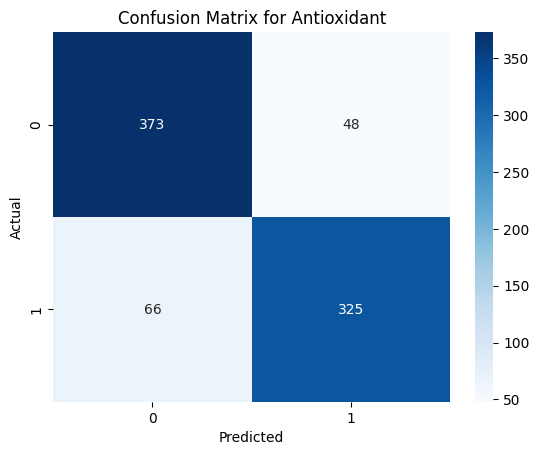

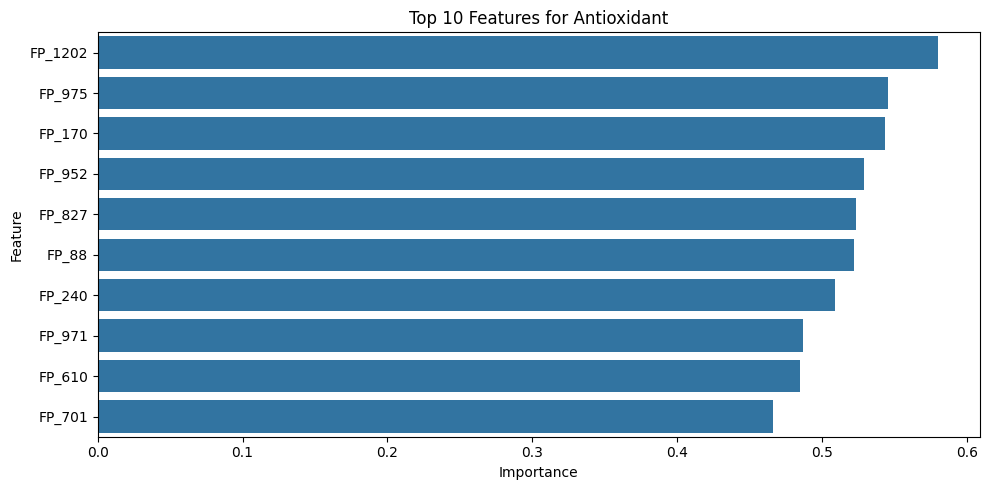

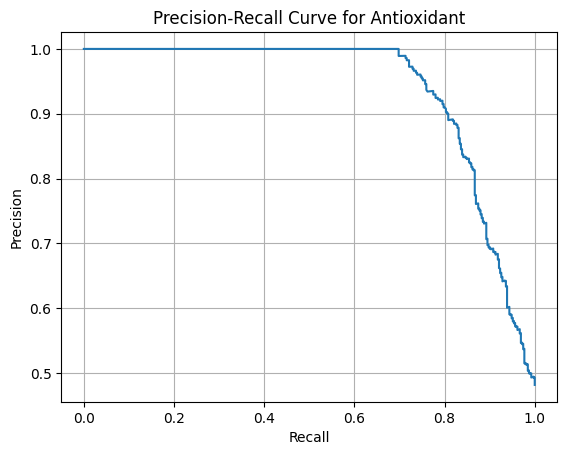

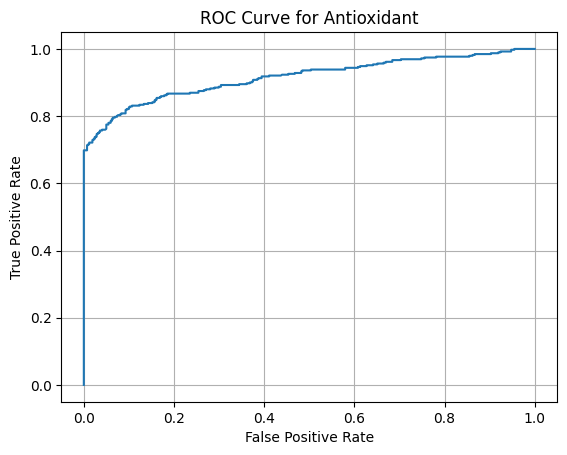


=== Linear SVM with Calibrated Probabilities for Anti-inflammatory Prediction ===
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Cross-validated accuracy: 0.8304568342920314
Cross-validated ROC AUC: 0.9053361494540271
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      2094
           1       0.90      0.73      0.81      1964

    accuracy                           0.83      4058
   macro avg       0.84      0.83      0.83      4058
weighted avg       0.84      0.83      0.83      4058

Best Parameters: {'estimator__C': 0.1, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'estimator__tol': 1e-05}
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       421
           1       0.89      0.90      0.89       391

    accuracy                           0.90       812
   macro avg       0.90      0.90      0.90       812
weighted avg       0.90      0.90      

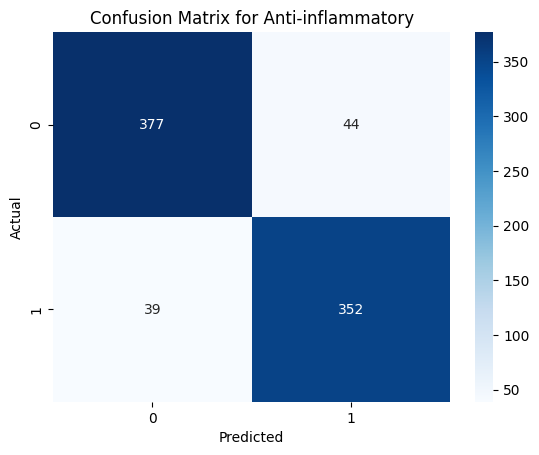

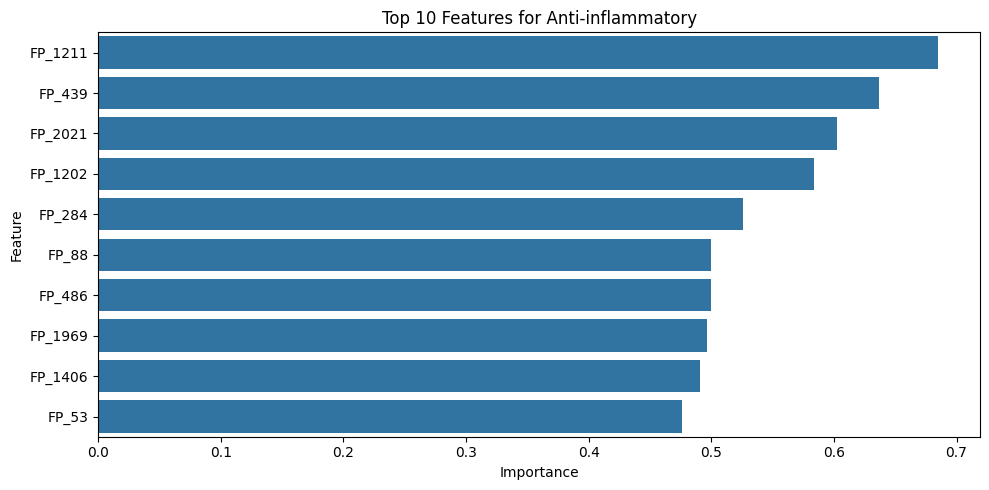

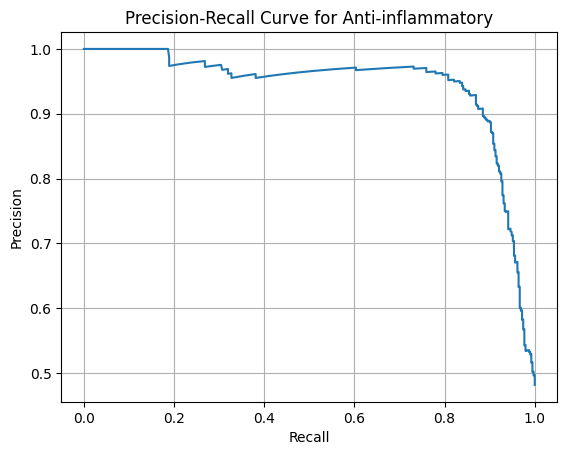

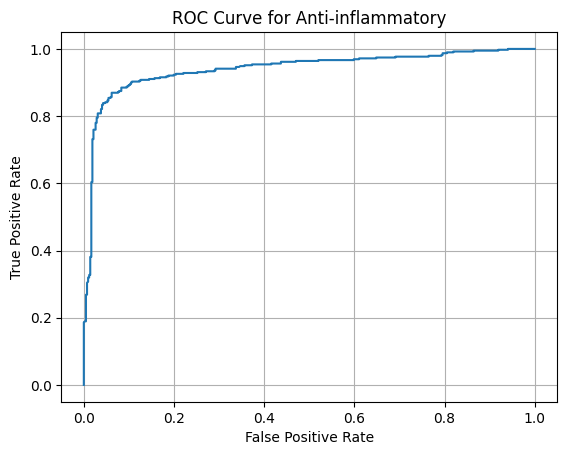


=== Linear SVM with Calibrated Probabilities for Toxic Prediction ===
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Cross-validated accuracy: 0.799401092126123
Cross-validated ROC AUC: 0.8766506944751387
              precision    recall  f1-score   support

           0       0.89      0.70      0.78      2084
           1       0.74      0.90      0.81      1974

    accuracy                           0.80      4058
   macro avg       0.81      0.80      0.80      4058
weighted avg       0.82      0.80      0.80      4058

Best Parameters: {'estimator__C': 1, 'estimator__loss': 'squared_hinge', 'estimator__penalty': 'l2', 'estimator__tol': 0.01}
              precision    recall  f1-score   support

           0       0.90      0.81      0.85       416
           1       0.82      0.91      0.86       396

    accuracy                           0.86       812
   macro avg       0.86      0.86      0.86       812
weighted avg       0.86      0.86      0.86       812



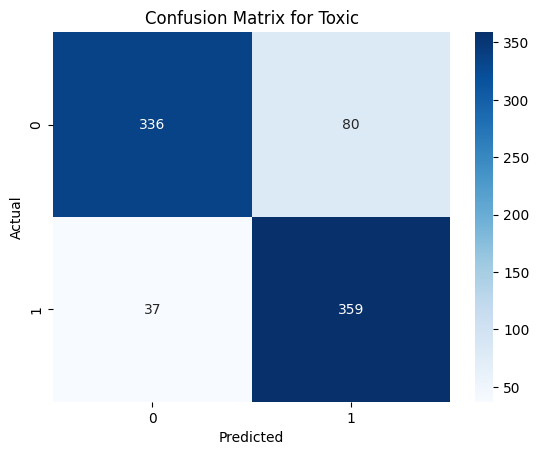

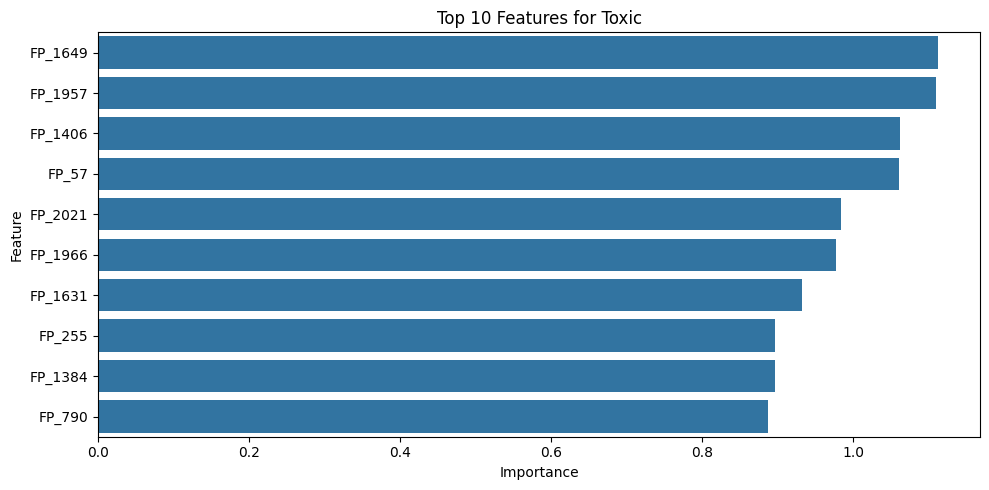

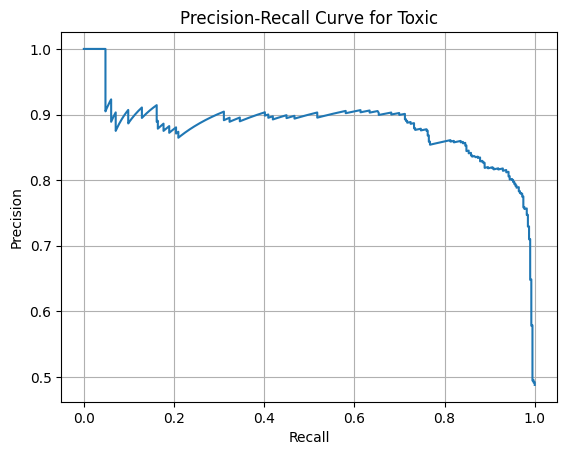

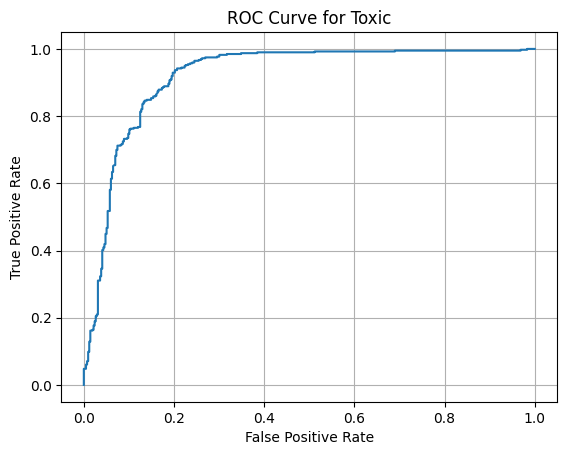

In [ ]:
# === Load and preprocess data ===
df = pd.read_csv("/content/QSAR-QSPR Finalized Dataset.csv")
smiles_list = df["SMILES"].tolist()

# Generate Morgan fingerprints
generator = GetMorganGenerator(radius=2, fpSize=2048)
fps = []
for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol:
        fp = generator.GetFingerprint(mol)
        arr = np.zeros((2048,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        fps.append(arr)
    else:
        fps.append(np.zeros((2048,), dtype=int))
fps_np = np.array(fps)

# Prepare the dataset
df = df.drop(columns=["SMILES", "IUPAC_NAME", "NAME"])
target_cols = ['Antioxidant', 'Anti-inflammatory', 'Toxic']
df[target_cols] = df[target_cols].astype(int)

# Feature engineering
features = df.drop(columns=target_cols).select_dtypes(include='number')
features_imputed = KNNImputer(n_neighbors=5).fit_transform(features)
X_scaled = StandardScaler().fit_transform(features_imputed)
X_combined = np.hstack([X_scaled, fps_np])

# === Modeling for each target ===
for target in target_cols:
    print(f"\n=== Linear SVM with Calibrated Probabilities for {target} Prediction ===")

    # For each target:
    y = df[target]

    # Split first
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

    # Feature selection on training set only
    selector_kbest = SelectKBest(f_classif, k=1000).fit(X_train, y_train)
    X_train_filtered = selector_kbest.transform(X_train)
    X_test_filtered = selector_kbest.transform(X_test)  # Same transformation for test set

    # RFE for feature selection on filtered set
    base_linear_svc = LinearSVC(max_iter=5000, dual=False, random_state=42)
    rfe = RFE(estimator=base_linear_svc, n_features_to_select=750)
    rfe.fit(X_train_filtered, y_train)
    X_train_selected = rfe.transform(X_train_filtered)
    X_test_selected = rfe.transform(X_test_filtered)

    # Define base model and calibrated model
    base_model = LinearSVC(max_iter=5000, dual=False, random_state=42)
    calibrated_model = CalibratedClassifierCV(estimator=base_model, method='sigmoid', cv=3)

    # Refined hyperparameter grid with more exploration
    param_grid = {
        'estimator__C': [0.001, 0.01, 0.1, 1, 10, 20, 50, 100],  # Regularization strength for LinearSVC
        'estimator__penalty': ['l2', 'elasticnet'],  # Penalty options for LinearSVC
        'estimator__loss': ['squared_hinge'],  # Loss function for LinearSVC
        'estimator__tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]  # Tolerance values for convergence in LinearSVC
    }

    # Use 5-fold cross-validation instead of 3 for better validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
    search = GridSearchCV(calibrated_model, param_grid=param_grid, cv=cv, verbose=1, n_jobs=-1)

    # Fit on the selected features
    search.fit(X_train_selected, y_train)

    # Best model from the randomized search
    best_model = search.best_estimator_

    # Now use cross-validation to evaluate the final model's performance
    cv_scores = cross_val_score(best_model, X_combined, y, cv=5, scoring='accuracy')
    print("Cross-validated accuracy:", cv_scores.mean())

    # Alternatively, you can calculate other evaluation metrics with cross-validation:
    cv_roc_auc = cross_val_score(best_model, X_combined, y, cv=5, scoring='roc_auc')
    print("Cross-validated ROC AUC:", cv_roc_auc.mean())

    # You can also use cross_val_predict to get predictions for the entire dataset
    from sklearn.model_selection import cross_val_predict
    y_pred_cv = cross_val_predict(best_model, X_combined, y, cv=5)

    # Evaluation metrics for cross-validation predictions
    print(classification_report(y, y_pred_cv))

    # Predictions
    y_prob = best_model.predict_proba(X_test_selected)[:, 1]
    y_pred = (y_prob >= 0.4).astype(int)

    # Evaluation
    print("Best Parameters:", search.best_params_)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_prob))

    # Confusion Matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {target}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # === Feature Importance via LinearSVC coefficients ===

    # Fit inner estimator separately so we can access coef_
    best_linear_svc = best_model.estimator
    best_linear_svc.fit(X_train_selected, y_train)
    coef = np.abs(best_linear_svc.coef_.flatten())

    # Recover feature names from selection steps
    selected_kbest_mask = selector_kbest.get_support()
    all_features = np.array(features.columns.tolist() + [f'FP_{i}' for i in range(2048)])
    kbest_features = all_features[selected_kbest_mask]

    rfe_mask = rfe.get_support()
    final_features = kbest_features[rfe_mask]

    # Pair feature names with coefficients
    feat_df = pd.DataFrame({'Feature': final_features, 'Importance': coef})
    feat_df = feat_df.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=feat_df.head(10))
    plt.title(f"Top 10 Features for {target}")
    plt.tight_layout()
    plt.show()

    # PR Curve
    precisions, recalls, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {target}")
    plt.grid(True)
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {target}")
    plt.grid(True)
    plt.show()
